In [1]:
!conda init

/bin/bash: line 1: conda: command not found


In [2]:
from sklearn.manifold import MDS
from scipy.spatial.distance import squareform
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap
import torch
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import LabelEncoder
import geoopt  # For hyperbolic geometry operations


In [40]:
import os
import torch
from sklearn.preprocessing import LabelEncoder

# Path to your folder
folder_path = "/mnt/ssd1/mary/Diffusion-Models-Embedding-Space-Defense/embeddings_cache"

# Find all files ending with '.pt' but NOT 'all_embeddings.pt'
embedding_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path)
                   if f.endswith(".pt") and 'all_embeddings' not in f]

all_tensors = []
all_strings = []

# Load and unpack each file
for file_path in embedding_files:
    data = torch.load(file_path)
    for tensor, category_string in data:
        # Split the category string into multiple labels
        subcaptions = [label.strip() for label in category_string.split(',')]
        for label in subcaptions:
            all_tensors.append(tensor.clone())  # Avoid shared reference
            all_strings.append(label)

# Stack all tensors
loaded_data = torch.stack(all_tensors)

# Encode the labels into integers
le = LabelEncoder()
labels = le.fit_transform(all_strings)
captions = torch.tensor(labels, dtype=torch.long)

# Print stats
print(f"Tensor shape: {loaded_data.shape}")
print(f"Number of labels: {len(captions)}")
print(f"Unique classes: {le.classes_}")


Tensor shape: torch.Size([12126, 768])
Number of labels: 12126
Unique classes: ['benign' 'harassment' 'hate' 'illegal activity' 'malicious' 'self-harm'
 'sexual' 'shocking' 'violence']


In [41]:
import umap
import torch

# Convert embeddings to numpy if needed
if isinstance(loaded_data, torch.Tensor):
    embedding_tensor = loaded_data.cpu().numpy()
else:
    embedding_tensor = loaded_data

# Convert captions to numpy
captions_tensor = captions  # assuming this is a torch.Tensor
captions_np = captions_tensor.cpu().numpy()

# Run UMAP with supervision using captions
hyperbolic_mapper = umap.UMAP(
    n_components=3,
    output_metric='hyperboloid',
    target_metric='categorical',
    random_state=42
).fit(embedding_tensor, y=captions_np)



/mnt/ssd1/mary/micromamba/envs/safe-clip/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


(12126, 3)


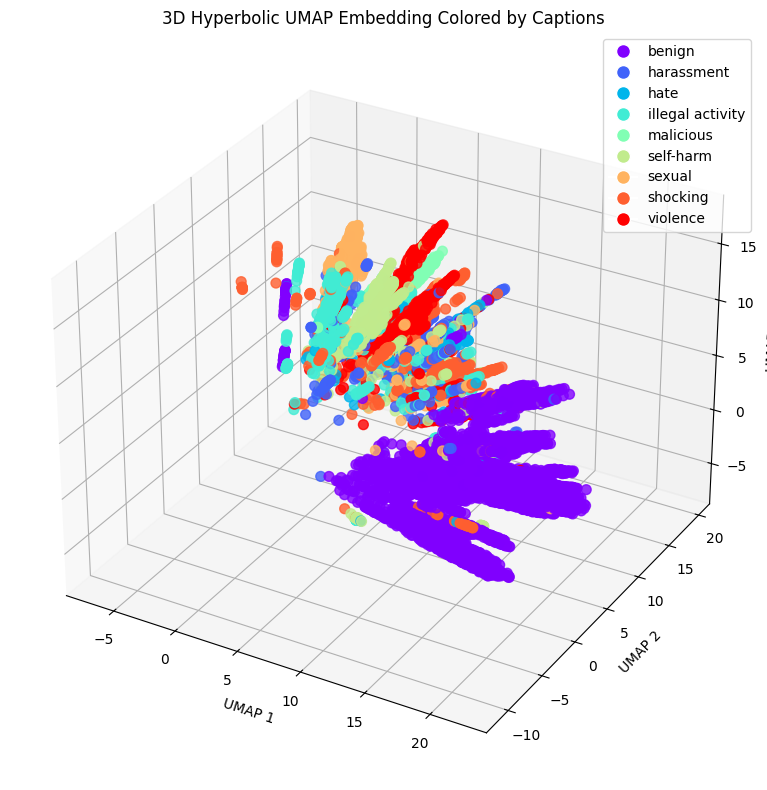

In [42]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np

# After fitting UMAP with supervision:
embedding_3d = hyperbolic_mapper.embedding_  # shape (N, 3)
print(embedding_3d.shape)

# Prepare labels
labels = captions_np  # numeric labels for coloring
# Assuming captions_np contains string labels (like 'cat', 'dog', etc.)
unique_labels_str = np.unique(captions_np)
class_names = unique_labels_str.tolist()
n_colors = len(class_names)
colormap = plt.cm.rainbow(np.linspace(0, 1, n_colors))
custom_cmap = ListedColormap(colormap)

# 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Map string labels to numeric indices for coloring
label_to_idx = {label: idx for idx, label in enumerate(class_names)}
numeric_labels = np.array([label_to_idx[label] for label in captions_np])

scatter = ax.scatter(
    embedding_3d[:, 0], embedding_3d[:, 1], embedding_3d[:, 2],
    c=numeric_labels, cmap=custom_cmap, s=50, alpha=0.8
)

# Create legend with class names
class_names = le.classes_  
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w',
               markerfacecolor=custom_cmap(i), markersize=10,
               label=class_names[i])
    for i in range(n_colors)
]
ax.legend(handles=legend_elements, loc='upper right')

ax.set_xlabel('UMAP 1')
ax.set_ylabel('UMAP 2')
ax.set_zlabel('UMAP 3')
ax.set_title('3D Hyperbolic UMAP Embedding Colored by Captions')

plt.tight_layout()
plt.show()
